In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
#from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from skfeature.function.similarity_based.lap_score import lap_score, feature_ranking
from sklearn.metrics import pairwise_distances
from scipy import sparse
import warnings
#from metrics import *
warnings.filterwarnings("ignore")
plt.style.use('seaborn-whitegrid')
from weight_matrices import compute_W_multiquadric_kernel
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

<br>

In [2]:
texturas = pd.read_excel('BBDD_caEnd_articulo_jmCarot.xlsx', usecols='DG:FKW')
grado = pd.read_excel('BBDD_caEnd_articulo_jmCarot.xlsx', usecols='AT')

na_ind = [47, 91, 94, 97]
texturas = texturas.drop(na_ind)
grado = grado.drop(na_ind)

grado_dico = grado.replace({1:0, 2:1, 3:1})

In [3]:
X_texturas = texturas.values
scaler = StandardScaler()
X_texturas_scaled = scaler.fit_transform(X_texturas)
Y = grado_dico.values.T[0] 

<br>

In [4]:
def confidence_intervals_for_each_laplacian_threshold(f, L, X_texturas_scaled, Y, model, thresholds = 250, experiments = 20):
    
    def thresholds_search(f, L, X, number_thresholds = 320):
        percentil = 1
        while True:
            if X[:,f[L[f] < np.percentile(L, percentil)]].shape[1] >= 160:
                break
            percentil += 0.2
        obs_ini = 1
        while True:
            if X[:,f[L[f] < L[f][obs_ini]]].shape[1] > 0:
                break
            obs_ini += 1
            
        return np.linspace(L[f][obs_ini], np.percentile(L, percentil), number_thresholds)
    
    random_states = set(np.random.random_integers(3000, size = (1, experiments))[0])
    results = {}
    n_vbles_last = 79999
    laplacian_thresholds = thresholds_search(f, L, X_texturas_scaled, number_thresholds = thresholds)
    best_auc_laplacian_threshold = (0, 0, 0) #auc, lap.threshold, random state
    for i in laplacian_thresholds:
        # Variables con un valor de Laplacian Score menor que el threshold
        X_texturas_selected = X_texturas_scaled[:,f[L[f] < i]]
        aucs = []
        accs = []
        # Si con el threshold obtenemos el mismo número de variables que antes, nos lo saltamos
        if X_texturas_selected.shape[1] == n_vbles_last:
            pass
        auc_max_rand_state = (0, 0)
        for rand_state in random_states:
            kf = StratifiedKFold(n_splits=10, shuffle = True, random_state = rand_state)
            probas = np.zeros((X_texturas_selected.shape[0],2))
            accs_aux_cv = []
            for train_index, test_index in kf.split(X_texturas_selected, Y):
                X_train, X_test = X_texturas_selected[train_index], X_texturas_selected[test_index]
                y_train, y_test = Y[train_index], Y[test_index]
                dt = model
                probas_ = dt.fit(X_train, y_train).predict_proba(X_test)
                accs_aux_cv.append(dt.score(X_test, y_test))
                probas[test_index, :] = probas_
            
            fpr, tpr, thresholds_for_roc = roc_curve(Y, probas[:, 1])
            acc = np.array(accs_aux_cv).mean()
            roc_auc = auc(fpr, tpr)
            if roc_auc > auc_max_rand_state[0]:
                auc_max_rand_state = (roc_auc, rand_state)
            aucs.append(roc_auc)
            accs.append(acc)
        
        aucs = np.array(aucs)
        accs = np.array(accs)
        auc_mean, accs_mean = aucs.mean(), accs.mean()
        auc_std, accs_std = aucs.std(), accs.std()
        auc_max, accs_max = max(aucs), max(accs)
        auc_min, accs_min = min(aucs), min(accs)
        if auc_mean > best_auc_laplacian_threshold[0]:
            best_auc_laplacian_threshold = (auc_mean, i, auc_max_rand_state[1] )
        n_vbles = X_texturas_selected.shape[1]
        n_vbles_last = n_vbles
        results[i] = [(auc_mean, auc_std, auc_max, auc_min, n_vbles), 
                      (accs_mean, accs_std, accs_max, accs_min, n_vbles)
                     ]
    return results, best_auc_laplacian_threshold

In [5]:
def thresholds_search(f, L, X, number_thresholds = 320):
    percentil = 1
    while True:
        if X[:,f[L[f] < np.percentile(L, percentil)]].shape[1] >= 160:
            break
        percentil += 0.2
    obs_ini = 1
    while True:
        if X[:,f[L[f] < L[f][obs_ini]]].shape[1] > 0:
            break
        obs_ini += 1
    return np.linspace(L[f][obs_ini], np.percentile(L, percentil), number_thresholds)

In [6]:
def get_cross_validation_threshold(X_texturas_scaled, Y, f, L, laplacian_thresholds, dt, random_state = 344):
    results = {}
    for i in laplacian_thresholds:
        X_texturas_selected = X_texturas_scaled[:,f[L[f] < i]] # Variables con un valor de Laplacian Score menor que el threshold

        kf = StratifiedKFold(n_splits=10, shuffle = True, random_state = random_state)
        probas = np.zeros((X_texturas_selected.shape[0],2))
        for train_index, test_index in kf.split(X_texturas_selected, Y):
            X_train, X_test = X_texturas_selected[train_index], X_texturas_selected[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            probas_ = dt.fit(X_train, y_train).predict_proba(X_test)
            probas[test_index, :] = probas_
        fpr, tpr, _ = roc_curve(Y, probas[:, 1])
        roc_auc = auc(fpr, tpr)
        results[i] = roc_auc
    return results

## LDA -- Laplacian con kernel multiquadric

### Hyperparameter search Weight matrix

In [7]:
for eps in [77.9, 250, 5000]:
    print('[INFO] eps = {}'.format(eps))
    W = compute_W_multiquadric_kernel(X_texturas_scaled, Y, eps, 0.5)
    L = lap_score(X_texturas_scaled, W = sparse.csr_matrix(W))
    f = feature_ranking(L)
    laplacian_thresholds = thresholds_search(f, L, X_texturas_scaled, number_thresholds = 20)
    dt = LinearDiscriminantAnalysis()
    results = get_cross_validation_threshold(X_texturas_scaled, Y, f, L, laplacian_thresholds, dt)
    print(max([(v, c) for c, v in results.items()]))
    print()

[INFO] eps = 77.9
(0.5622227151730257, 0.6743934205866506)

[INFO] eps = 250
(0.666259982253771, 0.9994805725203431)

[INFO] eps = 5000
(0.6875554569653949, 0.9994946810480928)



In [8]:
eps = 5000
W = compute_W_multiquadric_kernel(X_texturas_scaled, Y, eps, 0.5)
L = lap_score(X_texturas_scaled, W = sparse.csr_matrix(W))
f = feature_ranking(L)

In [11]:
model = LinearDiscriminantAnalysis()
results, best_auc_laplacian_threshold = confidence_intervals_for_each_laplacian_threshold(
                                                            f, L, 
                                                            X_texturas_scaled, 
                                                            Y, 
                                                            model, 
                                                            thresholds = 320, 
                                                            experiments = 20)

In [13]:
auc_mean, auc_std, auc_max, auc_min, c, n_vbles = max([(mean_, std_, max_, min_, c, n_vbles) for c, [(mean_, std_, max_, min_, n_vbles),_] in results.items()])
print('[INFO] Best threshold: {}'.format(c))
print('AUC mean: {}'.format(auc_mean))
print('AUC std: {}'.format(auc_std))
print('AUC max: {}'.format(auc_max))
print('AUC min: {}'.format(auc_min))
print('AUC medio: {} Máximo AUC: {}  con un random state de {} y un laplacian threshold de {}'.format(best_auc_laplacian_threshold[0], 
                                                                                                      auc_max,
                                                                                                      best_auc_laplacian_threshold[2],
                                                                                                      best_auc_laplacian_threshold[1]))

[INFO] Best threshold: 1.000205488208652
AUC mean: 0.6666259982253772
AUC std: 0.01602340126974029
AUC max: 0.6925465838509316
AUC min: 0.6367568766637091
AUC medio: 0.6666259982253772 Máximo AUC: 0.6925465838509316  con un random state de 2045 y un laplacian threshold de 0.9996052510508464


In [14]:
acc_mean, acc_std, acc_max, acc_min, c, n_vbles = max([(mean_, std_, max_, min_, c, n_vbles) for c, [_,(mean_, std_, max_, min_, n_vbles)] in results.items()])
print('[INFO] Best threshold: {}'.format(c))
print('Accuracy mean: {}'.format(acc_mean))
print('Accuracy std: {}'.format(acc_std))
print('Accuracy max: {}'.format(acc_max))
print('Accuracy min: {}'.format(acc_min))

[INFO] Best threshold: 0.9925524644466313
Accuracy mean: 0.7047142857142857
Accuracy std: 0.005676262383692817
Accuracy max: 0.7161904761904763
Accuracy min: 0.6880952380952381


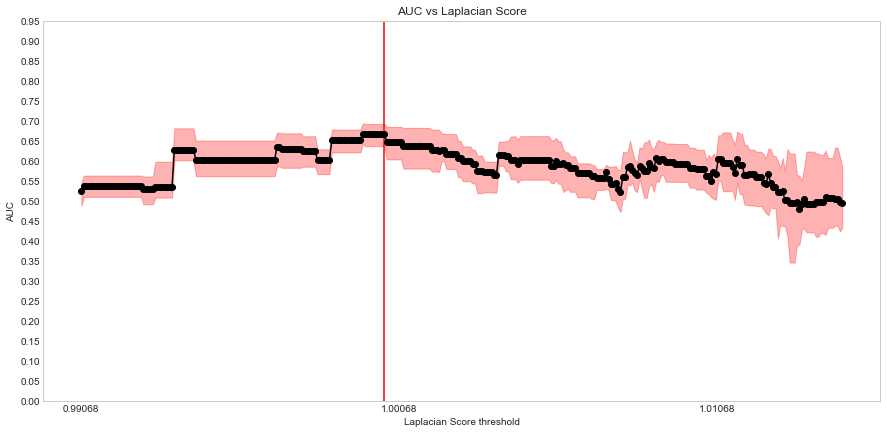

In [15]:
fig = plt.figure(figsize=(15,7))
plt.axvline(x = max([(auc_mean, c) for c, [(auc_mean, auc_std, auc_max, auc_min, n_vbles),_] in results.items()])[1], color = 'r')
plt.plot(results.keys(), [i[0][0] for i in results.values()], '-ok')
plt.fill_between(results.keys(),[i[0][3] for i in results.values()],[i[0][2] for i in results.values()], alpha=0.3, edgecolor='red', facecolor='red')
plt.grid(False)
plt.yticks(np.arange(0, 1, step=0.05))
plt.xticks(np.arange(min(laplacian_thresholds), max(laplacian_thresholds), step = 0.01))
plt.title('AUC vs Laplacian Score')
plt.xlabel('Laplacian Score threshold')
plt.ylabel('AUC')
plt.show()

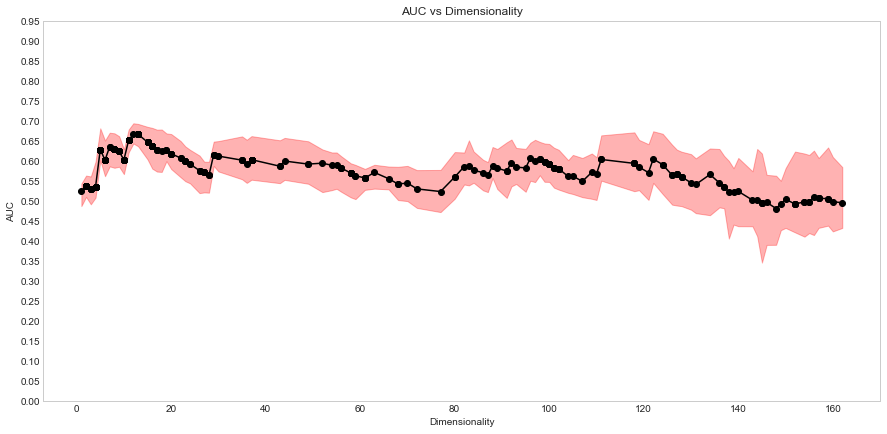

In [16]:
fig = plt.figure(figsize=(15,7))
n_vbles_x = [i[0][4] for i in results.values()]
aucs_y = [i[0][0] for i in results.values()]
plt.plot(n_vbles_x, aucs_y, '-ok')
plt.fill_between(n_vbles_x,[i[0][3] for i in results.values()],[i[0][2] for i in results.values()], alpha=0.3, edgecolor='red', facecolor='red')
plt.grid(False)
plt.yticks(np.arange(0, 1, step=0.05))
#plt.xticks(np.arange(min(laplacian_thresholds), max(laplacian_thresholds), step = 0.01))
plt.title('AUC vs Dimensionality')
plt.xlabel('Dimensionality')
plt.ylabel('AUC')
plt.show()

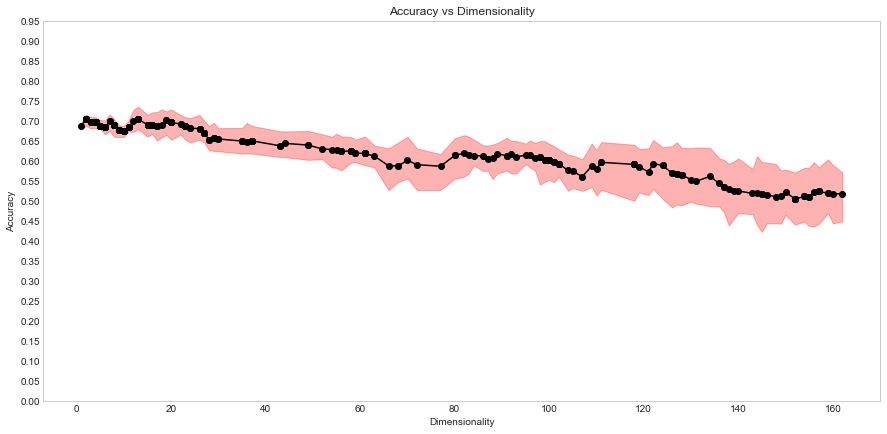

In [17]:
fig = plt.figure(figsize=(15,7))
n_vbles_x = [i[1][4] for i in results.values()]
accs_y = [i[1][0] for i in results.values()]
plt.plot(n_vbles_x, accs_y, '-ok')
plt.fill_between(n_vbles_x,[i[1][3] for i in results.values()],[i[1][2] for i in results.values()], alpha=0.3, edgecolor='red', facecolor='red')
plt.grid(False)
plt.yticks(np.arange(0, 1, step=0.05))
#plt.xticks(np.arange(min(laplacian_thresholds), max(laplacian_thresholds), step = 0.01))
plt.title('Accuracy vs Dimensionality')
plt.xlabel('Dimensionality')
plt.ylabel('Accuracy')
plt.show()

In [18]:
df_lap_lda_kenel = pd.DataFrame({'Threshold': list(results.keys()),
                                 'Dimensionality': [i[0][4] for i in results.values()], 
                                 'AUC_Mean':[i[0][0] for i in results.values()], 
                                 'AUC_Std': [i[0][1] for i in results.values()],
                                 'AUC_Min': [i[0][3] for i in results.values()], 
                                 'AUC_Max': [i[0][2] for i in results.values()], 
                                 
                                 'acc_Mean':[i[1][0] for i in results.values()], 
                                 'acc_Std': [i[1][1] for i in results.values()],
                                 'acc_Min': [i[1][3] for i in results.values()], 
                                 'acc_Max': [i[1][2] for i in results.values()]
                                 
                                 })

In [19]:
df_lap_lda_kenel.to_excel('df_lap_lda_kernel_multiquadric.xlsx', index = False)

## Mejor modelo

El que obtiene el máximo AUC para el mejor threshold de laplacian Score

In [20]:
rand_state_best = best_auc_laplacian_threshold[2]
threshold_best = best_auc_laplacian_threshold[1]
X_texturas_selected = X_texturas_scaled[:,f[L[f] < threshold_best]]

kf = StratifiedKFold(n_splits=10, shuffle = True, random_state = rand_state_best)
probas = np.zeros((X_texturas_selected.shape[0],2))
for train_index, test_index in kf.split(X_texturas_selected, Y):
    X_train, X_test = X_texturas_selected[train_index], X_texturas_selected[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    dt = LinearDiscriminantAnalysis()
    probas_ = dt.fit(X_train, y_train).predict_proba(X_test)
    probas[test_index, :] = probas_

In [21]:
probs_df = pd.DataFrame(probas)
probs_df['Y'] = Y
probs_df.to_excel('Predictions_Laplacian_Score_LDA_multiquadric_kernel.xlsx')

## Intervalos confianza con más pruebas para el laplacian threshold

In [22]:
X_texturas_selected = X_texturas_scaled[:,f[L[f] < threshold_best]] 

random_states = set(np.random.random_integers(3000, size = (1, 200))[0]) # 200 experimentos

results_remuestreo = {'AUC': [], 'Accuracy':[]}
for rand_state in random_states:
    kf = StratifiedKFold(n_splits=10, shuffle = True, random_state = rand_state)
    probas = np.zeros((X_texturas_selected.shape[0],2))
    acc_cv = []
    for train_index, test_index in kf.split(X_texturas_selected, Y):
        X_train, X_test = X_texturas_selected[train_index], X_texturas_selected[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        dt = LinearDiscriminantAnalysis()
        probas_ = dt.fit(X_train, y_train).predict_proba(X_test)
        acc_cv.append(dt.score(X_test, y_test))
        probas[test_index, :] = probas_
    acc = np.array(acc_cv).mean()
    fpr, tpr, thresholds_for_roc = roc_curve(Y, probas[:, 1])
    roc_auc = auc(fpr, tpr)
    results_remuestreo['AUC'].append(roc_auc)
    results_remuestreo['Accuracy'].append(acc)

In [23]:
media_auc = np.array(results_remuestreo['AUC']).mean()
std_auc = np.array(results_remuestreo['AUC']).std()
media_acc = np.array(results_remuestreo['Accuracy']).mean()
std_acc = np.array(results_remuestreo['Accuracy']).std()

print_value = lambda n, mean, std: print('{}: mean: {} - std: {}'.format(n, mean, std))
print_value('AUC', media_auc, std_auc)
print_value('Accuracy', media_acc, std_acc)

AUC: mean: 0.6703017318664344 - std: 0.01834853704192248
Accuracy: mean: 0.7078164322723908 - std: 0.012430712857095485
